In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Titanic dataset from the CSV file
df = pd.read_csv("/content/drive/My Drive/WEEK2AI/titanic.csv")


In [ ]:
# Display information about the dataset before cleaning
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_male    891 non-null    bool   
 7   Embarked_Q  891 non-null    bool   
 8   Embarked_S  891 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 44.5 KB


Summary Statistics:

In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


*Constructing One Hot Encoding for Label Vector*:

In [ ]:
X = df.drop(columns=['Survived']).values  # Feature matrix
y = df['Survived'].values  # Target vector

# One-Hot Encoding the target vector
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Display the one-hot encoded target vector
print("One-Hot Encoded Target Vector:")
print(y_onehot)


One-Hot Encoded Target Vector:
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


Train Test Splitand Standard Scaling of the Data:

In [ ]:
# Handle missing values without using inplace=True
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# drop columns that are not useful for modeling
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# One-Hot Encode categorical columns
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

X = df.drop(columns=['Survived']).values  # Feature matrix
y = df['Survived'].values  # Target vector

# One-Hot Encoding the target vector
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)

# scaler and scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assertions to check the shape of X_train_scaled and X_test_scaled
assert X_train_scaled.shape == (X_train.shape[0], X_train.shape[1]), f"X_train_scaled shape mismatch: {X_train_scaled.shape}"
assert X_test_scaled.shape == (X_test.shape[0], X_test.shape[1]), f"X_test_scaled shape mismatch: {X_test_scaled.shape}"

print("Shape assertions passed!")


Shape assertions passed!


4.Training of the Softmax Regression:

In [ ]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-10)) / y_true.shape[0]

def compute_gradients(X, y_true, y_pred):
    n_samples = X.shape[0]
    grad_W = np.dot(X.T, (y_pred - y_true)) / n_samples
    grad_b = np.sum(y_pred - y_true, axis=0) / n_samples
    return grad_W, grad_b

def gradient_descent(X, y, W, b, alpha, n_iter):
    cost_history = []
    for _ in range(n_iter):
        z = np.dot(X, W) + b
        y_pred = softmax(z)
        cost = compute_loss(y, y_pred)
        cost_history.append(cost)
        grad_W, grad_b = compute_gradients(X, y, y_pred)
        W -= alpha * grad_W
        b -= alpha * grad_b
    return W, b, cost_history

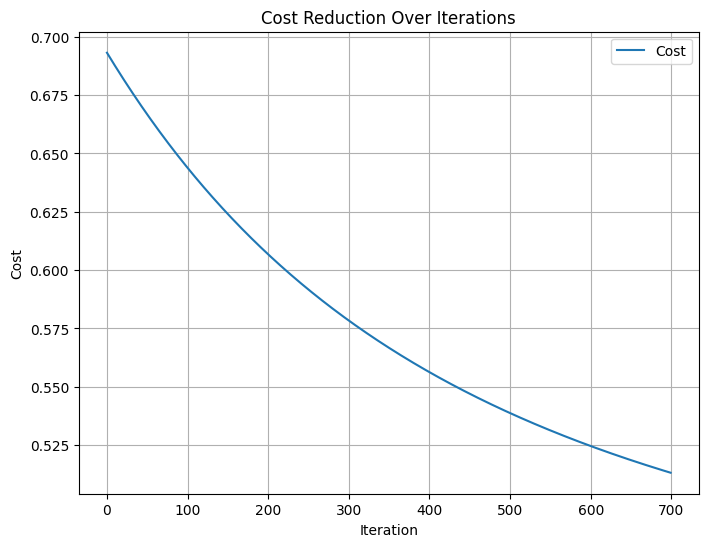

In [ ]:
# Set parameters
n_features = X_train_scaled.shape[1]
n_classes = y_train.shape[1]
W = np.zeros((n_features, n_classes))
b = np.zeros(n_classes)
learning_rate = 0.002
n_iterations = 700

# Train the model
W_opt, b_opt, cost_history = gradient_descent(X_train_scaled, y_train, W, b, learning_rate, n_iterations)

# Plot cost history
plt.figure(figsize=(8, 6))
plt.plot(range(n_iterations), cost_history, label="Cost")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Reduction Over Iterations")
plt.legend()
plt.grid()
plt.show()

Evaluating the Model

In [ ]:

def predict(X, W, b):
    z = np.dot(X, W) + b
    y_pred_prob = softmax(z)
    return np.argmax(y_pred_prob, axis=1)

def evaluate_model(X, y_true, W, b):
    y_pred = predict(X, W, b)
    y_true_labels = np.argmax(y_true, axis=1)
    accuracy = np.mean(y_pred == y_true_labels) * 100
    return accuracy, y_pred

# Evaluate on test data
test_accuracy, y_test_pred = evaluate_model(X_test_scaled, y_test, W_opt, b_opt)

# Confusion matrix and classification report
y_test_true_labels = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred)
class_report = classification_report(y_test_true_labels, y_test_pred, target_names=["Did Not Survive", "Survived"])

print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Test Accuracy: 76.54%
Confusion Matrix:
[[89 21]
 [21 48]]
Classification Report:
                 precision    recall  f1-score   support

Did Not Survive       0.81      0.81      0.81       110
       Survived       0.70      0.70      0.70        69

       accuracy                           0.77       179
      macro avg       0.75      0.75      0.75       179
   weighted avg       0.77      0.77      0.77       179

